<a href="https://colab.research.google.com/github/kmoy14-stanford/AA203-Homework/blob/master/HW2/AA_203_HW_2_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.integrate import odeint
import jax
import jax.numpy as jnp
import time

Load in animations.py

```
# lmao I hope this works
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/animations.py .

from animations import animate_cartpole

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Linearization

In [ ]:
@jax.partial(jax.jit, static_argnums=(0,))
def linearize(f, s, u):
    """Linearize the function `f(s,u)` around `(s,u)`."""
    # WRITE YOUR CODE BELOW ###################################################
    A, B = jax.jacfwd(f, (0, 1) )(s, u)
    ###########################################################################
    return A, B


# ILQR

In [ ]:
def ilqr(f, s0, s_goal, N, Q, R, Qf):
    """Compute the iLQR set-point tracking solution.
    Arguments
    ---------
    f : Callable
        A function describing the discrete-time dynamics, such that
        `s[k+1] = f(s[k], u[k])`.
    s0 : numpy.ndarray
        The initial state (1-D).
    s_goal : numpy.ndarray
        The goal state (1-D).
    N : int
        The time horizon of the LQR cost function.
    Q : numpy.ndarray
        The state cost matrix (2-D).
    R : numpy.ndarray
        The control cost matrix (2-D).
    Qf : numpy.ndarray
        The terminal state cost matrix (2-D).
    Returns
    -------
    s_bar : numpy.ndarray
        A 3-D array where `s_bar[k]` is the nominal state at time step `k`,
        for `k = 0, 1, ..., N-1`
    u_bar : numpy.ndarray
        A 3-D array where `u_bar[k]` is the nominal control at time step `k`,
        for `k = 0, 1, ..., N-1`
    L : numpy.ndarray
        A 3-D array where `L[k]` is the matrix gain term of the iLQR control
        law at time step `k`, for `k = 0, 1, ..., N-1`
    l : numpy.ndarray
        A 3-D array where `l[k]` is the offset term of the iLQR control law
        at time step `k`, for `k = 0, 1, ..., N-1`
    """
    n = Q.shape[0]        # state dimension
    m = R.shape[0]        # control dimension
    eps = 0.001           # termination threshold for iLQR
    max_iters = int(1e3)  # maximum number of iLQR iterations

    # Initialize control law terms `L` and `l`
    L = np.zeros((N, m, n))
    l = np.zeros((N, m))

    # Initialize `u`, `u_bar`, `s`, and `s_bar` with a forward pass
    u_bar = np.zeros((N, m))
    s_bar = np.zeros((N + 1, n))
    s_bar[0] = s0
    for k in range(N):
        s_bar[k+1] = f(s_bar[k], u_bar[k])
    u = np.copy(u_bar)
    s = np.copy(s_bar)

    # iLQR loop
    converged = False
    for it in range(max_iters):
        # print("Loop Iteration: {}".format(it))
        # Linearize the dynamics at each step `k` of `(s_bar, u_bar)`
        A, B = jax.vmap(linearize, in_axes=(None, 0, 0))(f, s_bar[:-1], u_bar)
        A, B = np.array(A), np.array(B)

        # WRITE YOUR CODE BELOW ###############################################
        # Update the arrays `L`, `l`, `s`, and `u`.
        del_u = np.zeros((N, m))

        ## --- BACKWARD PASS ---
        # First do end step (at k = N)
        Q_N = 0.5 * np.dot((s_bar[N] - s_goal).T, np.dot(Qf, (s_bar[N] - s_goal)))
        # Initialize value function terms to backwards-recursively iterate
        V = Qf
        v_vec = np.dot(Qf.T, (s_bar[N] - s_goal))
        v = Q_N
        for k in range(N-1,0,-1):
            # print("Iteration: {}".format(k))
            # Compute Q terms (3.48-3.53 in notes)
            c_k = 0.5 * np.dot((s_bar[k]-s_goal).T, np.dot(Q, (s_bar[k]-s_goal))) + 0.5 * np.dot(u_bar[k].T, np.dot(R, u_bar[k]))
            c_xk = np.dot(Q, (s_bar[k]-s_goal))
            c_uk = np.dot(R, (u_bar[k]))
            f_xk = A[k]
            f_uk = B[k]
            Q_k = c_k + v
            Q_xk = c_xk + np.dot(f_xk.T, v_vec)
            Q_uk = c_uk + np.dot(f_uk.T, v_vec)
            Q_xxk = Q + np.dot(f_xk.T, np.dot(V, f_xk))
            Q_uuk = R + np.dot(f_uk.T, np.dot(V, f_uk))
            Q_uxk = 0 + np.dot(f_uk.T, np.dot(V, f_xk))
            # Update feedback law (3.55-3.56 in notes)
            l[k] = np.dot(-np.linalg.inv(Q_uuk), Q_uk)
            L[k] = np.dot(-np.linalg.inv(Q_uuk), Q_uxk)
            # Update value approximation
            v = Q_k - 0.5 * np.dot(l[k].T, np.dot(Q_uuk, l[k]))
            v_vec = Q_xk - np.dot(L[k].T, np.dot(Q_uuk, l[k]))
            V = Q_xxk - np.dot(L[k].T, np.dot(Q_uuk, L[k]))
        # print(l)

        ## --- FORWARD PASS ---
        s[0] = s0
        for k in range(N):
            del_u[k] = l[k] + np.dot(L[k], (s[k] - s_bar[k]))
            s[k+1] = f(s[k], u_bar[k] + del_u[k])
        u = u_bar + del_u
        # print(u)
        # print(u_bar)
        #######################################################################

        if np.max(np.abs(u - u_bar)) < eps:
            converged = True
            break
        else:
            u_bar[:] = u
            s_bar[:] = s
    if not converged:
        raise RuntimeError('iLQR did not converge!')
    return s_bar, u_bar, L, l

## Cartpole state-derivative

In [ ]:
def cartpole(s, u):
    """Compute the cart-pole state derivative."""
    mp = 2.     # pendulum mass
    mc = 10.    # cart mass
    ℓ = 1.      # pendulum length
    g = 9.81    # gravitational acceleration

    x, θ, dx, dθ = s
    sinθ, cosθ = jnp.sin(θ), jnp.cos(θ)
    h = mc + mp*(sinθ**2)
    ds = jnp.array([
        dx,
        dθ,
        (mp*sinθ*(ℓ*(dθ**2) + g*cosθ) + u[0]) / h,
        -((mc + mp)*g*sinθ + mp*ℓ*(dθ**2)*sinθ*cosθ + u[0]*cosθ) / (h*ℓ)
    ])
    return ds

# RUN THIS

Streaming output truncated to the last 5000 lines.
[[-33.33333019]]
[[-57.91505655]]
[[-63.91851023]]
[[-63.46548443]]
[[-59.93952433]]
[[-55.3593904]]
[[-51.20386842]]
[[-48.13750478]]
[[-46.12490173]]
[[-44.85055064]]
[[-44.01124562]]
[[-43.40676812]]
[[-42.93048282]]
[[-42.53586905]]
[[-42.20742348]]
[[-41.94170799]]
[[-41.73722792]]
[[-41.59034208]]
[[-41.49460423]]
[[-41.44162623]]
[[-41.42230511]]
[[-41.42785737]]
[[-41.45048774]]
[[-41.48371337]]
[[-41.52243442]]
[[-41.56284674]]
[[-41.60227281]]
[[-41.63896217]]
[[-41.67190031]]
[[-41.70059445]]
[[-41.72499142]]
[[-41.74525161]]
[[-41.76174827]]
[[-41.77491061]]
[[-41.78522272]]
[[-41.79315001]]
[[-41.79912003]]
[[-41.80354172]]
[[-41.80676647]]
[[-41.80903263]]
[[-41.81062847]]
[[-41.81169938]]
[[-41.81243041]]
[[-41.81288206]]
[[-41.81317406]]
[[-41.81333428]]
[[-41.81341826]]
[[-41.81342186]]
[[-41.8133801]]
[[-41.81326751]]
[[-41.81307973]]
[[-41.81280856]]
[[-41.81243878]]
[[-41.81199791]]
[[-41.81149415]]
[[-41.8109714]]


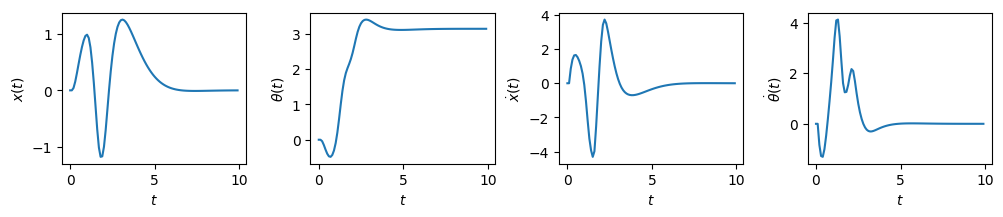

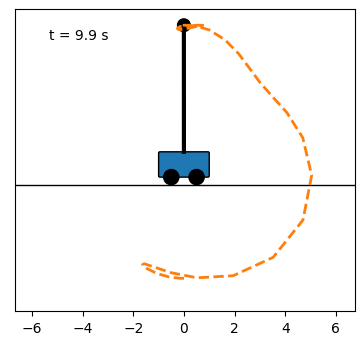

In [ ]:

if __name__ == "__main__":  # may have to comment this out for this notebook
    n = 4                                      # state dimension
    m = 1                                      # control dimension
    Q = np.diag(np.array([10., 10., 2., 2.]))  # state cost matrix
    R = 1e-2*np.eye(m)                         # control cost matrix
    Qf = 1e2*np.eye(n)                         # terminal state cost matrix
    s0 = np.array([0., 0., 0., 0.])            # initial state
    s_goal = np.array([0., np.pi, 0., 0.])     # goal state
    T = 10.                                    # simulation time
    dt = 0.1                                   # sampling time

    # Initialize continuous-time and discretized dynamics
    f = jax.jit(cartpole)
    f_discrete = jax.jit(lambda s, u, dt=dt: s + dt*f(s, u))

    # Compute the iLQR solution with the discretized dynamics
    print('Computing iLQR solution ... ', end='', flush=True)
    start = time.time()
    t = np.arange(0., T, dt)
    N = t.size - 1
    s_bar, u_bar, L, l = ilqr(f_discrete, s0, s_goal, N, Q, R, Qf)
    print('done! ({:.2f} s)'.format(time.time() - start), flush=True)

    # Simulate on the true continuous-time system
    print('Simulating ...', end='', flush=True)
    simulate_continuous_time_dynamics = True  # change to `True` in part (d)
    start = time.time()
    s = np.zeros((N + 1, n))
    u = np.zeros((N, m))
    s[0] = s0
    for k in range(N):
        if simulate_continuous_time_dynamics:
            # WRITE YOUR CODE BELOW ###########################################
            # Update `u[k]` using the final LQR policy `L`, `l` output by
            # `ilqr` above to track the planned trajectory when we simulate the
            # continuous-time dynamics.
            u[k] = u_bar[k] + l[k] + np.dot(L[k], (s[k] - s_bar[k]))
            ###################################################################
            s[k+1] = odeint(lambda s, t: f(s, u[k]), s[k], t[k:k+2])[1]
        else:
            u[k] = u_bar[k]
            s[k+1] = f_discrete(s[k], u[k])
    print('done! ({:.2f} s)'.format(time.time() - start), flush=True)

    # Plot
    fig, axes = plt.subplots(1, n, dpi=100, figsize=(12, 2))
    plt.subplots_adjust(wspace=0.35)
    ylabels = (r'$x(t)$', r'$\theta(t)$',
               r'$\dot{x}(t)$', r'$\dot{\theta}(t)$')
    for i in range(n):
        axes[i].plot(t, s[:, i])
        axes[i].set_xlabel(r'$t$')
        axes[i].set_ylabel(ylabels[i])
    plt.savefig('cartpole_swingup.pdf', bbox_inches='tight')

    fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
    ani.save('cartpole_swingup.mp4', writer='ffmpeg')
    plt.show()

In [ ]:
Qf

array([[100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.]])

In [ ]:
Qf.T

array([[100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.]])

In [ ]:
2 * Qf * (s0 - s_goal)

array([[   0.        ,   -0.        ,    0.        ,    0.        ],
       [   0.        , -628.31853072,    0.        ,    0.        ],
       [   0.        ,   -0.        ,    0.        ,    0.        ],
       [   0.        ,   -0.        ,    0.        ,    0.        ]])

In [ ]:
s0-s_goal

array([ 0.        , -3.14159265,  0.        ,  0.        ])